In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tqdm import tqdm_notebook as tqdm
import re 

from pymysql import *
host_name = '172.16.0.205'
port_name = 3306
user_name = 'root'
psw = 'root123456'

# 读取通话记录

In [5]:
call_df = pd.read_csv('../data/call_record.csv',encoding = 'utf-8',names = ['id','phoneNumber','creater_id','login_name','customer_id','call_duration'])
print(call_df.shape)
print(call_df.info())
call_df.head()

(2003038, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2003038 entries, 0 to 22037
Data columns (total 6 columns):
id               int64
phoneNumber      object
creater_id       int64
login_name       object
customer_id      int64
call_duration    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 107.0+ MB
None


/Users/luocheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,phoneNumber,creater_id,login_name,customer_id,call_duration
0,1,009DBED95AEF9383677FC4BF0A74242C,7750899339529601024,100008,7798519551527272448,0.0
1,2,009DBED95AEF9383677FC4BF0A74242C,7750899339529601024,100008,7798519551527272448,0.0
2,3,00DF0F708C23D4702B814B19DCD1FC5B,7750899339529601024,100008,7704841561720360960,0.0
3,4,01AB4CCE0002C1098DCDFD828277551E,7750899339529601024,100008,16198845,0.0
4,5,01AB4CCE0002C1098DCDFD828277551E,7750899339529601024,100008,16198845,0.0


# 读取历史分配记录、调库记录

In [6]:
def column_from_mysql(database_name,table_name):
    conn=connect(host = host_name,port = port_name,user = user_name, password = psw,charset = 'utf8',database = database_name)
    cs1 = conn.cursor()
    


    count2 = cs1.execute('SHOW FULL FIELDS FROM %s' % table_name)
    result2 = list(cs1.fetchall())
    columns = [column_set[0] for column_set in result2]

    cs1.close()
    conn.close()
    print("查询到%d条数据:" % count2)
    return columns

columns = column_from_mysql('IBOSS_ MACHINE_LEARNING','customer_record')
columns

查询到19条数据:


['id',
 'record_id',
 'business_id',
 'table_name',
 'customer_id',
 'from_user_id',
 'to_user_id',
 'create_time',
 'content',
 'OpCode',
 'OpName',
 'YtCode',
 'YtName',
 'creater_id',
 'phoneNumber',
 'login_name',
 'real_name',
 'followStart',
 'followEnd']

In [10]:
allocation_df = pd.read_csv('../data/customer_record.csv',encoding = 'utf-8',names = columns)
print(allocation_df.shape)
print(allocation_df.info())
allocation_df.head()

(3816581, 19)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816581 entries, 0 to 2053757
Data columns (total 19 columns):
id              int64
record_id       int64
business_id     int64
table_name      object
customer_id     int64
from_user_id    float64
to_user_id      float64
create_time     object
content         object
OpCode          object
OpName          object
YtCode          object
YtName          object
creater_id      int64
phoneNumber     object
login_name      object
real_name       object
followStart     object
followEnd       object
dtypes: float64(2), int64(5), object(12)
memory usage: 582.4+ MB
None


,id,record_id,business_id,table_name,customer_id,from_user_id,to_user_id,create_time,content,OpCode,OpName,YtCode,YtName,creater_id,phoneNumber,login_name,real_name,followStart,followEnd
0,1,7796908554573365248,17995339,bus_business,3420755,NaN,NaN,2019-03-21 11:14:32,打电话,CALL_CUSTOMER,打电话,BUS_YT_DK_XYDK,信用贷款,7794384374728024064,9BB57F2AA23BEAAB6BB303094654ED42,103214,李林娟,2019-03-21 11:14:32,2019-03-21 11:25:09
1,2,7796908554925686784,7667130008686829568,bus_business,7667130008707801088,NaN,NaN,2019-03-21 11:14:32,打电话,CALL_CUSTOMER,打电话,BUS_YT_DK_XYDK_1,信贷小贷（禁）,7727417444839636992,17A97B8BD3B41299210F3D4EE7E13C86,923978593,徐江俊,2019-03-21 11:14:32,2019-04-02 14:15:08
2,3,7796908554937614336,7794068173515440128,bus_business,7794068182228058112,NaN,NaN,2019-03-21 11:14:32,打电话,CALL_CUSTOMER,打电话,BUS_YT_DK_XYDK,信用贷款,7786511542414139392,0FEA17714DE3C60A3DF31136ED1E2B97,101624,谢腾腾,2019-03-21 11:14:32,2019-03-26 10:12:48
3,4,7796908555747770368,7793601322146652160,bus_business,885775,NaN,NaN,2019-03-21 11:14:33,无人应答或客户暂时无法接听,BUS_3,跟进,BUS_YT_DK_XYDK,信用贷款,7764014573878435840,0F8755E2E9DD60B7E1CC6D345CBD2B46,100967,钟晓芹,2019-03-21 11:14:33,2019-03-26 16:25:31
4,5,7796908555763892224,7774622885687336960,bus_business,7774622886081601536,NaN,7.733555e+18,2019-03-21 11:14:33,拾回自跟进,BUS_IN_4,拾回自跟进,BUS_YT_DK_XYDK,信用贷款,7733554909571760128,1B0B8527EA843E2E6D2439667578BA87,973547908,钱家伟,2019-03-21 11:14:33,2019-03-25 17:19:15


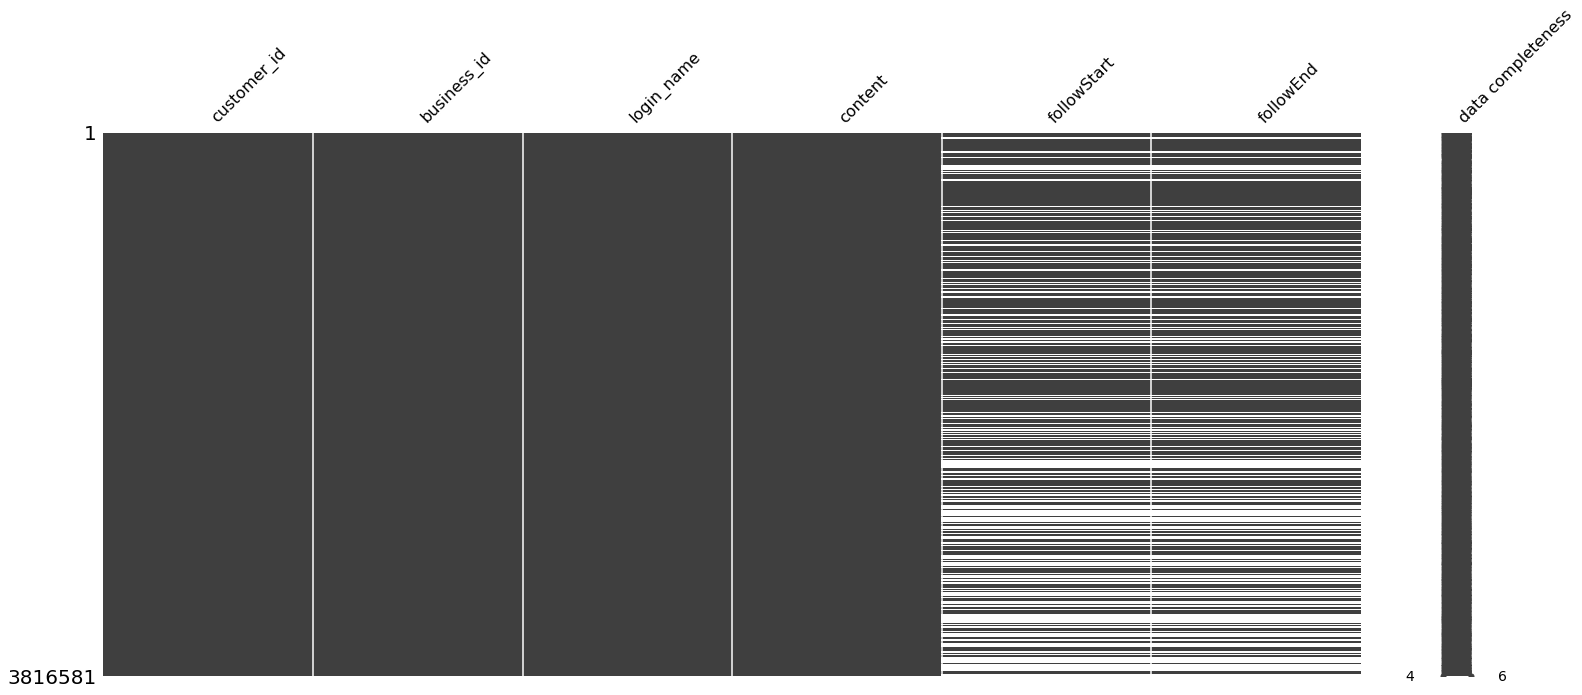

In [12]:
allocation_df = allocation_df[['customer_id','business_id','login_name','content','followStart','followEnd']]
msno.matrix(allocation_df, labels=True)

In [13]:
allocation_df.dropna(inplace=True)
print(allocation_df.shape)
print(allocation_df.info())
allocation_df.head()

(2366629, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2366629 entries, 0 to 2053743
Data columns (total 6 columns):
customer_id    int64
business_id    int64
login_name     object
content        object
followStart    object
followEnd      object
dtypes: int64(2), object(4)
memory usage: 126.4+ MB
None


,customer_id,business_id,login_name,content,followStart,followEnd
0,3420755,17995339,103214,打电话,2019-03-21 11:14:32,2019-03-21 11:25:09
1,7667130008707801088,7667130008686829568,923978593,打电话,2019-03-21 11:14:32,2019-04-02 14:15:08
2,7794068182228058112,7794068173515440128,101624,打电话,2019-03-21 11:14:32,2019-03-26 10:12:48
3,885775,7793601322146652160,100967,无人应答或客户暂时无法接听,2019-03-21 11:14:33,2019-03-26 16:25:31
4,7774622886081601536,7774622885687336960,973547908,拾回自跟进,2019-03-21 11:14:33,2019-03-25 17:19:15


# 构造新特征--跟进总天数、分配次数

In [14]:
import time
allocation_df['follow_days']=pd.to_datetime(allocation_df["followEnd"]) - pd.to_datetime(allocation_df["followStart"])
allocation_df['follow_hour']=pd.to_datetime(allocation_df['follow_days']).dt.hour 
allocation_df['follow_minute']=pd.to_datetime(allocation_df['follow_days']).dt.minute
allocation_df['follow_days']=pd.to_datetime(allocation_df['follow_days']).dt.day 
allocation_df.head()

/Users/luocheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: Passing timedelta64-dtype data is deprecated, will raise a TypeError in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


,customer_id,business_id,login_name,content,followStart,followEnd,follow_days,follow_hour,follow_minute
0,3420755,17995339,103214,打电话,2019-03-21 11:14:32,2019-03-21 11:25:09,1,0,10
1,7667130008707801088,7667130008686829568,923978593,打电话,2019-03-21 11:14:32,2019-04-02 14:15:08,13,3,0
2,7794068182228058112,7794068173515440128,101624,打电话,2019-03-21 11:14:32,2019-03-26 10:12:48,5,22,58
3,885775,7793601322146652160,100967,无人应答或客户暂时无法接听,2019-03-21 11:14:33,2019-03-26 16:25:31,6,5,10
4,7774622886081601536,7774622885687336960,973547908,拾回自跟进,2019-03-21 11:14:33,2019-03-25 17:19:15,5,6,4


# 计算通话时长的MinMaxScaler

In [15]:
call_group = call_df.groupby(['login_name','customer_id']).agg({'call_duration':np.mean}).reset_index()
call_group.dropna(inplace=True)
print(call_group.shape)
print(call_group.info())
call_group.head()

(642464, 3)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 642464 entries, 0 to 642463
Data columns (total 3 columns):
login_name       642464 non-null object
customer_id      642464 non-null int64
call_duration    642464 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 19.6+ MB
None


,login_name,customer_id,call_duration
0,100008,138905,8.5
1,100008,3676655,0.0
2,100008,4182405,0.0
3,100008,4268785,0.0
4,100008,4367905,0.0


In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

minmax_scale = preprocessing.MinMaxScaler().fit(call_group[['call_duration']])
call_group['call_score'] = minmax_scale.transform(call_group[['call_duration']])
call_group.head()

,login_name,customer_id,call_duration,call_score
0,100008,138905,8.5,0.003537
1,100008,3676655,0.0,0.000000
2,100008,4182405,0.0,0.000000
3,100008,4268785,0.0,0.000000
4,100008,4367905,0.0,0.000000


In [ ]:
minmax_scale = preprocessing.StandardScaler().fit(call_group[['call_duration']])
call_group['call_score'] = minmax_scale.transform(call_group[['call_duration']])
call_group.head()

# 计算跟进天数的MinMaxScaler

In [17]:
allocation_group = allocation_df.groupby(['login_name','business_id']).agg({'customer_id':lambda x: x.value_counts().index[0],'content':np.sum,'follow_days':np.mean,'follow_hour':np.mean}).reset_index()
allocation_group.dropna(inplace=True)
print(allocation_group.shape)
print(allocation_group.info())
allocation_group.head()

(775910, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 775910 entries, 0 to 775909
Data columns (total 6 columns):
login_name     775910 non-null object
customer_id    775910 non-null int64
business_id    775910 non-null int64
content        775910 non-null object
follow_days    775910 non-null float64
follow_hour    775910 non-null float64
dtypes: float64(2), int64(2), object(2)
memory usage: 41.4+ MB
None


,login_name,customer_id,business_id,content,follow_days,follow_hour
0,100008,138905,7662899713867522048,打电话打电话剔除商机。原因：客户三无客户已经明确表示不需要,1.0,0.0
1,100008,3676655,7709527585121767424,打电话,1.0,0.0
2,100008,4268785,7747633295609044992,打电话,1.0,0.0
3,100008,4367905,5948435,打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听,7.0,22.0
4,100008,4738045,7725647421052821504,打电话,1.0,0.0


In [18]:
allocation_group['follow_days'] = allocation_group['follow_days'] + allocation_group['follow_hour'] / 8 # 每天工作8小时
allocation_group.head()

,login_name,customer_id,business_id,content,follow_days,follow_hour
0,100008,138905,7662899713867522048,打电话打电话剔除商机。原因：客户三无客户已经明确表示不需要,1.00,0.0
1,100008,3676655,7709527585121767424,打电话,1.00,0.0
2,100008,4268785,7747633295609044992,打电话,1.00,0.0
3,100008,4367905,5948435,打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听,9.75,22.0
4,100008,4738045,7725647421052821504,打电话,1.00,0.0


In [19]:
minmax_scale = preprocessing.MinMaxScaler().fit(allocation_group[['follow_days']])
allocation_group['follow_score'] = minmax_scale.transform(allocation_group[['follow_days']])
allocation_group.head()

,login_name,customer_id,business_id,content,follow_days,follow_hour,follow_score
0,100008,138905,7662899713867522048,打电话打电话剔除商机。原因：客户三无客户已经明确表示不需要,1.00,0.0,0.0
1,100008,3676655,7709527585121767424,打电话,1.00,0.0,0.0
2,100008,4268785,7747633295609044992,打电话,1.00,0.0,0.0
3,100008,4367905,5948435,打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听打电话无人应答或客户暂时无法接听,9.75,22.0,0.4
4,100008,4738045,7725647421052821504,打电话,1.00,0.0,0.0


In [ ]:
minmax_scale = preprocessing.StandardScaler().fit(allocation_group[['follow_days']])
allocation_group['follow_score'] = minmax_scale.transform(allocation_group[['follow_days']])
allocation_group.head()

# 合并分配记录

In [21]:
print(call_group.shape,allocation_group.shape)
merge_df = pd.merge(call_group, allocation_group, on=['customer_id','login_name'], how = 'outer')
print(merge_df.shape)
print(merge_df.info())
merge_df.head()

(642464, 4) (775910, 7)
(1413567, 9)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413567 entries, 0 to 1413566
Data columns (total 9 columns):
login_name       1413567 non-null object
customer_id      1413567 non-null int64
call_duration    642464 non-null float64
call_score       642464 non-null float64
business_id      775910 non-null float64
content          775910 non-null object
follow_days      775910 non-null float64
follow_hour      775910 non-null float64
follow_score     775910 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 107.8+ MB
None


,login_name,customer_id,call_duration,call_score,business_id,content,follow_days,follow_hour,follow_score
0,100008,138905,8.5,0.003537,NaN,NaN,NaN,NaN,NaN
1,100008,3676655,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
2,100008,4182405,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
3,100008,4268785,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
4,100008,4367905,0.0,0.000000,NaN,NaN,NaN,NaN,NaN


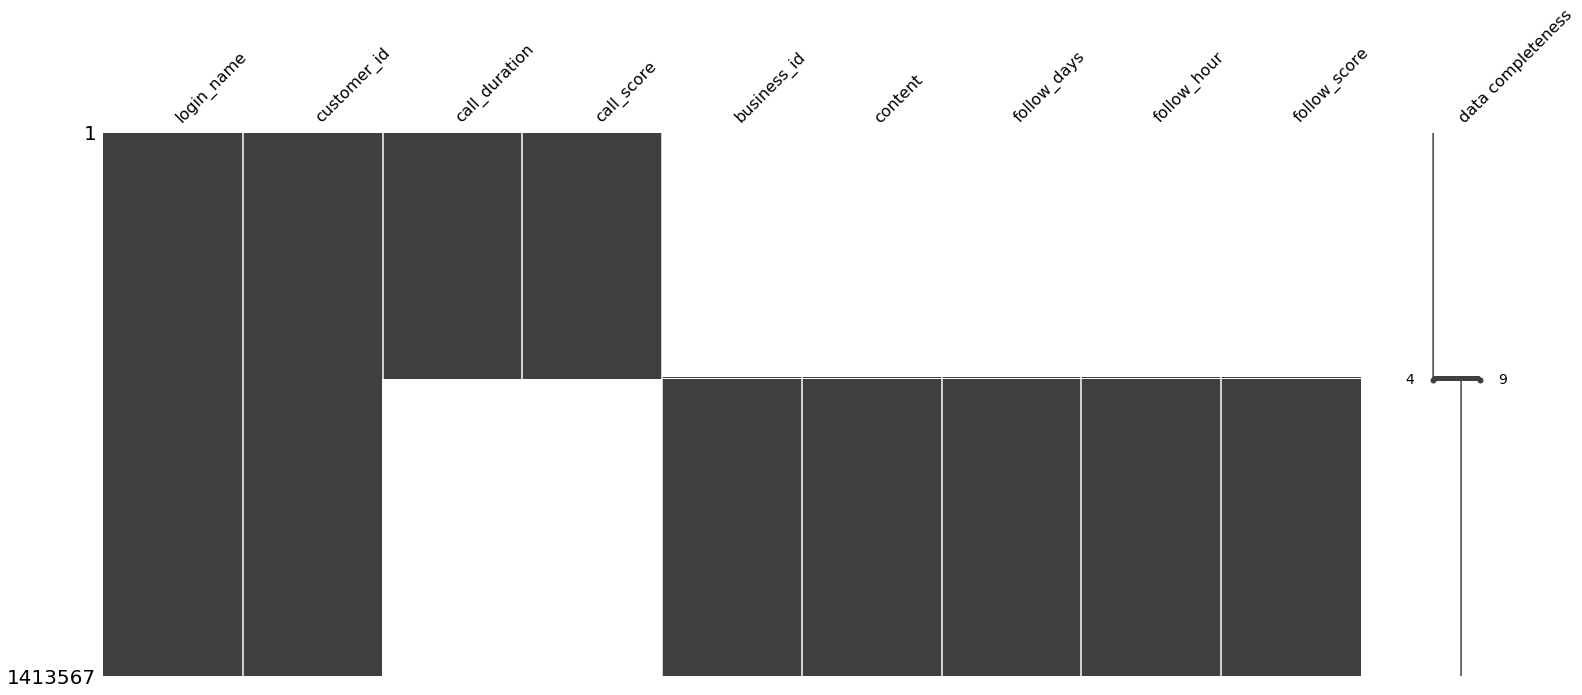

In [22]:
msno.matrix(merge_df, labels=True)

In [23]:
merge_df = merge_df[['login_name','business_id','customer_id','call_duration','follow_days','call_score','follow_score','content']]
print(merge_df.shape)
print(merge_df.info())
merge_df.head()

(1413567, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1413567 entries, 0 to 1413566
Data columns (total 8 columns):
login_name       1413567 non-null object
business_id      775910 non-null float64
customer_id      1413567 non-null int64
call_duration    642464 non-null float64
follow_days      775910 non-null float64
call_score       642464 non-null float64
follow_score     775910 non-null float64
content          775910 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 97.1+ MB
None


,login_name,business_id,customer_id,call_duration,follow_days,call_score,follow_score,content
0,100008,NaN,138905,8.5,NaN,0.003537,NaN,NaN
1,100008,NaN,3676655,0.0,NaN,0.000000,NaN,NaN
2,100008,NaN,4182405,0.0,NaN,0.000000,NaN,NaN
3,100008,NaN,4268785,0.0,NaN,0.000000,NaN,NaN
4,100008,NaN,4367905,0.0,NaN,0.000000,NaN,NaN


# 提取备注的工资信息

In [ ]:
merge_df['salary_score'] = 0
for i in tqdm(range(len(merge_df))):
    line = merge_df.iloc[i]['content']
    
    line = line.replace('几千','1000').replace('几万','10001').replace('多','')
    line = line.replace('一','1').replace('两','2').replace('二','2').replace('三','3').replace('四','4').replace('五','5').replace('六','6').replace('七','7').replace('八','8').replace('九','9')
    line = line.replace('百','00').replace('千','000').replace('万','0000').replace('员工资源','资源')
        
    ret = re.findall(r"\d+-\d+",line)
    for result in ret:
        line = line.replace(result,result.split('-')[-1])
    ret = re.findall(r"\d+",line)
    if len(ret):
        ret = re.findall(r".{0,10}\d+[万|千|w|W|K|k]?",line) # 税后工资七八千 流水一个月一两百万
        for result in ret:
            sub_ret = re.findall(r"代发|流水|发现金|税后|收入|打卡|工资",result)
            
            if len(sub_ret) > 0:
                sub_ret = re.findall(r"\d{1,3}多?[w|W|K|k]|\d{1,3}-\d{1,3}多?[w|W|K|k]",result)+re.findall(r"\d+-\d+",result)+re.findall(r"\d+",result)
                if len(sub_ret) > 0:
                    salary = sub_ret[0].split('-')[-1].replace('w','0000').replace('k','000').replace('W','0000').replace('K','000')
                    
                    merge_df.at[i,'salary_score'] = salary
                    print(ret)
                    print('工资:',salary)
                    break
            
    
    

In [ ]:
# 匹配小数
ret = re.findall(r"\d+\.\d+",'打电话打电话需要1.2万，现金/打卡工资4-5千，自己缴的社保，征信有点问题')
print(ret)

merge_df.head()

# 读取历史成单记录

In [25]:
order_df = pd.read_csv('../data/order2018-20190409.csv',encoding='utf-8')
order_df['login_name'] = order_df['user_no']
# order_df = order_df[['business_id','place_order_time','customer_id','login_name','product_amount']]
print(order_df.shape)
print(order_df.info())
order_df.head()

(117899, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117899 entries, 0 to 117898
Data columns (total 15 columns):
id                    117899 non-null int64
order_id              117899 non-null int64
business_id           117899 non-null int64
business_no           117899 non-null object
place_order_time      117899 non-null object
customer_id           117899 non-null int64
user_no               117748 non-null float64
business_user_name    117891 non-null object
organization_name     117899 non-null object
sign_org_name         117880 non-null object
business_type_name    117899 non-null object
bt_name               117889 non-null object
status                117899 non-null object
product_amount        117899 non-null float64
login_name            117748 non-null float64
dtypes: float64(3), int64(4), object(8)
memory usage: 13.5+ MB
None


,id,order_id,business_id,business_no,place_order_time,customer_id,user_no,business_user_name,organization_name,sign_org_name,business_type_name,bt_name,status,product_amount,login_name
0,7636349742137880576,7636349741634564096,7636348060347805696,SJ201801020021,2018-01-02 14:07:34,7636348060372971520,76245836.0,姜仙桥,重庆融资商务二中心商务八部,重庆融资事业部,信贷小贷,信用贷款,ORF_DDZT_2,12000.0,76245836.0
1,7636361066397970432,7636361066045648896,18270402,SJ201712291497502,2018-01-02 17:16:25,16294154,12034683.0,黄锋,重庆融资商务二中心商务五部,重庆融资事业部,信贷小贷,信用贷款,ORF_DDZT_6,50000.0,12034683.0
2,7636367610480959488,7636367609885368320,18273827,SJ201712301497777,2018-01-02 16:18:53,16296839,56802695.0,罗程露,重庆融资商务二中心商务五部,重庆融资事业部,信贷小贷,信用贷款,ORF_DDZT_2,70000.0,56802695.0
3,7636378209898209280,7636378209290035200,17966745,SJ201710301003641,2018-01-02 16:18:53,16048951,56783251.0,陈静,重庆融资商务二中心商务五部,重庆融资事业部,信贷小贷,信用贷款,ORF_DDZT_6,600000.0,56783251.0
4,7636379623751815168,7636379623177195520,17918754,SJ20171015906424,2018-01-02 15:41:26,16010715,97511357.0,娄世强,重庆融资商务二中心商务二部,重庆融资事业部,银行信贷,信用贷款,ORF_DDZT_2,50000.0,97511357.0


In [26]:
order_df['login_name']=order_df['login_name'].astype('object')
order_df['customer_id']=order_df['customer_id'].astype('int')
print(order_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117899 entries, 0 to 117898
Data columns (total 15 columns):
id                    117899 non-null int64
order_id              117899 non-null int64
business_id           117899 non-null int64
business_no           117899 non-null object
place_order_time      117899 non-null object
customer_id           117899 non-null int64
user_no               117748 non-null float64
business_user_name    117891 non-null object
organization_name     117899 non-null object
sign_org_name         117880 non-null object
business_type_name    117899 non-null object
bt_name               117889 non-null object
status                117899 non-null object
product_amount        117899 non-null float64
login_name            117748 non-null object
dtypes: float64(2), int64(4), object(9)
memory usage: 13.5+ MB
None


# 合并历史成单记录

In [27]:
print(merge_df.shape,order_df.shape)
merge_df = pd.merge(order_df, merge_df, on=['business_id','login_name'], how = 'outer')
print(merge_df.shape)
print(merge_df.info())
merge_df.head()

(1413567, 8) (117899, 15)
(1524967, 21)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1524967 entries, 0 to 1524966
Data columns (total 21 columns):
id                    117899 non-null float64
order_id              117899 non-null float64
business_id_x         117899 non-null float64
business_no           117899 non-null object
place_order_time      117899 non-null object
customer_id           1524967 non-null int64
user_no               117748 non-null float64
business_user_name    117891 non-null object
organization_name     117899 non-null object
sign_org_name         117880 non-null object
business_type_name    117899 non-null object
bt_name               117889 non-null object
status                117899 non-null object
product_amount        117899 non-null float64
login_name            1524816 non-null object
business_id_y         775910 non-null float64
call_duration         643064 non-null float64
follow_days           775910 non-null float64
call_score            643064

,id,order_id,business_id_x,business_no,place_order_time,customer_id,user_no,business_user_name,organization_name,sign_org_name,...,bt_name,status,product_amount,login_name,business_id_y,call_duration,follow_days,call_score,follow_score,content
0,7.636350e+18,7.636350e+18,7.636348e+18,SJ201801020021,2018-01-02 14:07:34,7636348060372971520,76245836.0,姜仙桥,重庆融资商务二中心商务八部,重庆融资事业部,...,信用贷款,ORF_DDZT_2,12000.0,7.62458e+07,NaN,NaN,NaN,NaN,NaN,NaN
1,7.636361e+18,7.636361e+18,1.827040e+07,SJ201712291497502,2018-01-02 17:16:25,16294154,12034683.0,黄锋,重庆融资商务二中心商务五部,重庆融资事业部,...,信用贷款,ORF_DDZT_6,50000.0,1.20347e+07,NaN,NaN,NaN,NaN,NaN,NaN
2,7.637153e+18,7.637153e+18,7.637151e+18,SJ201801040211,2018-01-04 16:28:57,16294154,12034683.0,黄锋,重庆融资商务二中心商务五部,重庆融资事业部,...,信用贷款,ORF_DDZT_6,50000.0,1.20347e+07,NaN,NaN,NaN,NaN,NaN,NaN
3,7.636368e+18,7.636368e+18,1.827383e+07,SJ201712301497777,2018-01-02 16:18:53,16296839,56802695.0,罗程露,重庆融资商务二中心商务五部,重庆融资事业部,...,信用贷款,ORF_DDZT_2,70000.0,5.68027e+07,NaN,NaN,NaN,NaN,NaN,NaN
4,7.636378e+18,7.636378e+18,1.796674e+07,SJ201710301003641,2018-01-02 16:18:53,16048951,56783251.0,陈静,重庆融资商务二中心商务五部,重庆融资事业部,...,信用贷款,ORF_DDZT_6,600000.0,5.67833e+07,NaN,NaN,NaN,NaN,NaN,NaN


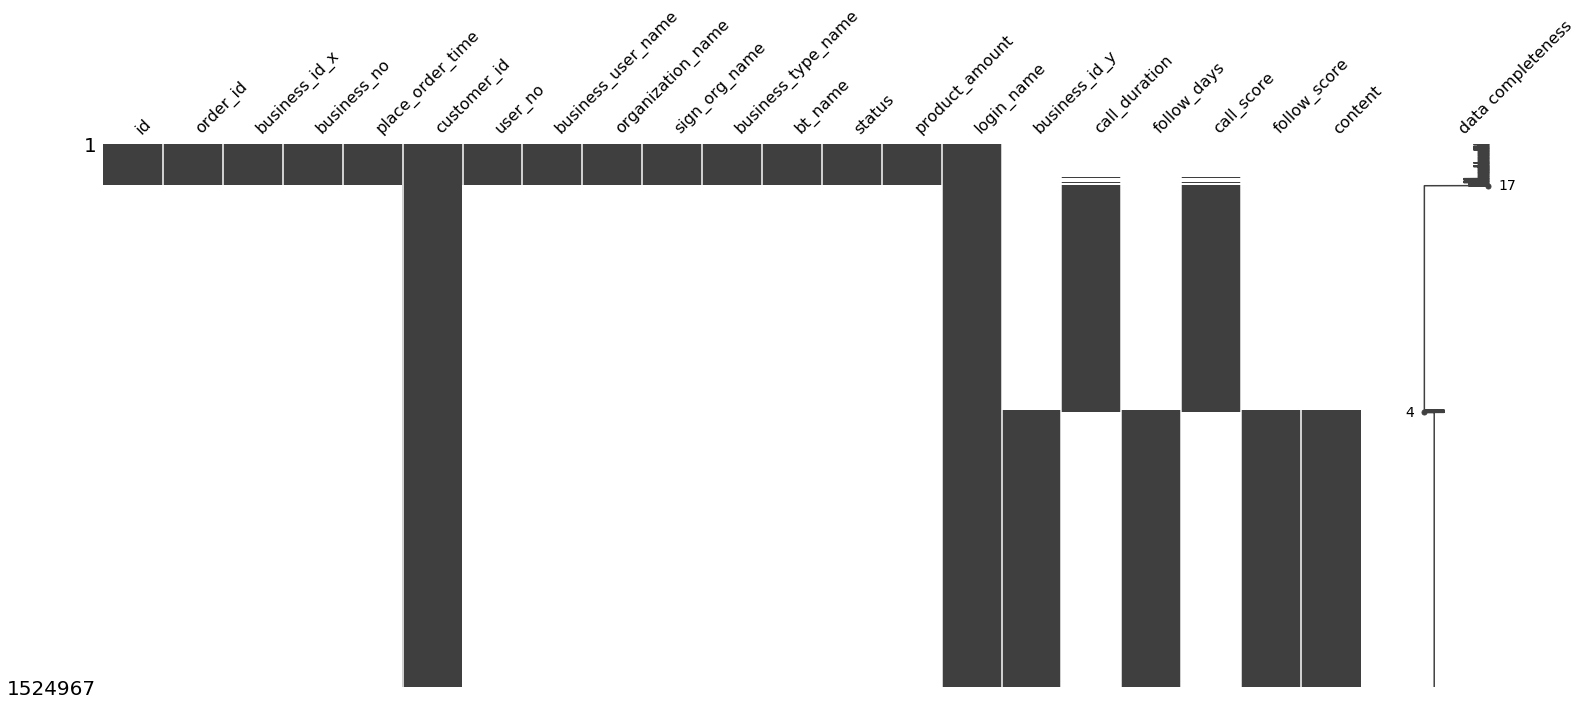

In [28]:
msno.matrix(merge_df, labels=True)

In [ ]:
writer = pd.ExcelWriter('score0424.xlsx')
merge_df.to_excel(writer,'Sheet1')
writer.save()

# 解析跟进记录中的备注字段

In [ ]:
contents = list(set(allocation_group['content'].values.tolist()))
print(len(contents))
contents

In [ ]:

num_content = []
for line in contents:
    ret = re.match(r"\d+",line)
    if ret:
        # 去除无用的数据 如zhy180726'
        ret = re.findall(r"[a-zA-Z]{1,9}\d+",line) 
        if len(ret) > 0:
            for result in ret:
                line = line.replace(result,'')
                
        # 提取时间
#         re.fi
        
        num_content.append(line)
print(len(num_content))
num_content    

In [ ]:
# re.findall(r"1[0-2]{1}月",'12月8号联系.....')
# re.findall(r"[1-9]{1}月",'004月8号联系.....')
# 将[万|千|w]替换为0000|000|0000
re.findall(r"\d{1,3}多?[万|千|w]|\d{1,3}-\d{1,3}多?[万|千|w]",'保单年缴5-6千')

In [ ]:
# 匹配工资
# re.findall(r"发现金[0-9][万|千]|税后收入打卡工资[0-9][万|千]",'打卡工资发现金2万')
# re.findall(r"发现金[0-9][万|千]|收入打卡工资[一|二|三|四|五|六|七|八|九][万|千]",'打卡工资发现金2万')
ret = re.findall(r".{0,10}\d+多?[万|千|w|K].{0,10}|.{0,10}\d+-\d+多?[万|千|w|K].{0,10}",'客户每个月发现金时15号，8-9千') # 税后工资七八千 流水一个月一两百万
print(ret)
if len(ret) > 0:
    sub_ret = re.findall(r"代发|流水|发现金|税后|收入|打卡|工资",ret[0])
    print(sub_ret)
    
    

In [ ]:
# 匹配负债
re.findall(r"[月供|还]{2}\d+000",'月供4100')

In [ ]:
剔除原因 | 剔除商机   扣分
营业执照10多年
要1万
查征信
手续费报的3-5个点
线上产品1分内客户都接受
4号早上11-12点  3-4点左右
【徐治琴72343078】 替换为 其他商务，其他商务作为外部词库
马灿森102473抢了商机
秦云飞915359587抢了商机
{"保单":"有","商品房":"有","实体店":"有","社保":"有","营业执照":"有","车":"有"}{贷款金额:30万}

## 备注分词

In [ ]:
import jieba.analyse
from wordcloud import WordCloud
import jieba

from gensim import corpora, models,similarities
import gensim

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl



def cut_record_content(content):
    content_S = []
    for i in range(len(content)):
        line = content[i]
        #print(line)
        if isinstance(line,float):
            print('(============)')
            print([])
            print('(============)')
            content_S.append([])
            continue
        current_segment = jieba.lcut(line)

    
        if current_segment != '\r\n':
            content_S.append(current_segment)
    return content_S

contents = cut_record_content(contents)
contents

In [ ]:
def dosegment_all(sentence):
    '''
    带词性标注，对句子进行分词，不排除停词等
    :param sentence:输入字符
    :return:
    '''
    sentence_seged = jieba.posseg.cut(sentence.strip())
    outstr = ''
    for x in sentence_seged:
        outstr+="{}/{},".format(x.word,x.flag)
    #上面的for循环可以用python递推式构造生成器完成
    # outstr = ",".join([("%s/%s" %(x.word,x.flag)) for x in sentence_seged])
    return outstr
if '没','无' in line:# 新词发现 如 没有资金  不需要  不想要等等
    dosegment_all('打电话现在没有资金缺口、客户已经明确表示不需要')

In [ ]:
360 同金额中过滤
要一千万 作为异常值过滤
手续费高
利息高


## 停用词处理

In [ ]:
stopwords=pd.read_csv("stopwords.txt",index_col=False,sep="\t",quoting=3,names=['stopword'], encoding='utf-8')
stopwords = stopwords.stopword.values.tolist()
print(len(stopwords))

In [ ]:
def drop_stopwords(contents,stopwords):
    contents_clean = []
    all_words = []
    for line in contents:
        line_clean = []
        for word in line:
            word = word.strip()
            if len(word) == 0:
                continue
            if word in stopwords:
                continue
            line_clean.append(word)
            all_words.append(str(word))
        contents_clean.append(line_clean)
    return contents_clean,all_words

contents_clean,all_words = drop_stopwords(contents,stopwords)

## 做词云图

In [ ]:
df_allWords = pd.DataFrame({'all_words':all_words})
allWords_count = df_allWords.groupby(by=['all_words'])['all_words'].agg({'count':np.size})
print(allWords_count['all_words'].values.tolist())
print(allWords_count.head())
allWords_count = allWords_count.reset_index().sort_values(by = ['count'],ascending=False)
print(allWords_count.shape)
allWords_count.head()

In [ ]:
wordcloud2 = WordCloud(font_path='simhei.ttf',background_color='white',max_font_size = 80)
word_frequence = {x[0]:x[1] for x in allWords_count.head(100).values}
wordcloud3 = wordcloud2.fit_words(word_frequence)
mpl.rcParams['figure.figsize'] = (30.0, 15.0) # set default size of plots
plt.imshow(wordcloud3)

In [ ]:
from PIL import Image
from wordcloud import ImageColorGenerator

alice_coloring = np.array(Image.open(r"D:\360安全浏览器下载\business.png"))
wordcloud2 = WordCloud(font_path='simhei.ttf',background_color="white", max_words=2000, mask=alice_coloring, max_font_size=80, random_state=42)
wordcloud3 = wordcloud2.fit_words(word_frequence)
plt.axis("off") # 去掉坐标轴
# 在只设置mask的情况下,你将会得到一个拥有图片形状的词云
plt.imshow(wordcloud3, interpolation="bilinear")

In [ ]:

plt.figure()
image_colors = ImageColorGenerator(alice_coloring)
plt.axis("off")
# recolor wordcloud and show
# we could also give color_func=image_colors directly in the constructor
# 我们还可以直接在构造函数中直接给颜色
# 通过这种方式词云将会按照给定的图片颜色布局生成字体颜色策略
plt.imshow(wordcloud2.recolor(color_func=image_colors), interpolation="bilinear")

In [2]:
df = pd.read_csv('../data/total_data_1.csv',encoding = 'utf-8')
print(df.shape)
print(df.info())
df.head()

/Users/luocheng/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (7,8,11,18,19,20,21,22,23,25,26,27,30,41,43,45,46,47,48,50,51,52,55,57,58,59,60,61,62,63,64,65,69,71,76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1672678, 83)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1672678 entries, 0 to 1672677
Data columns (total 83 columns):
avgAddWechatFriendCount    382995 non-null float64
avgCallCount               384790 non-null float64
avgIntentCustomerCount     325188 non-null float64
avgRemarkWords             384980 non-null float64
avgSignBillDays            229339 non-null float64
avgToDoorCount             207503 non-null float64
avgWorkHour                384957 non-null float64
businessType               385274 non-null object
entryDate                  385274 non-null object
loanRate                   261364 non-null float64
performanceRank            308445 non-null float64
realName                   385274 non-null object
signBillCount              334877 non-null float64
signBillRate               319075 non-null float64
statisticDay_x             385274 non-null float64
toDoorRate                 335183 non-null float64
userId_x                   385274 non-null float64
userNo_x 

,avgAddWechatFriendCount,avgCallCount,avgIntentCustomerCount,avgRemarkWords,avgSignBillDays,avgToDoorCount,avgWorkHour,businessType,entryDate,loanRate,...,coverCharge,refundOrderSign,signOderNum,oderStatistics,callTimes,avgCallDuration,call_score,follow_score,product_amount,salary_score
0,0.591,69.0,0.32,24.59,NaN,0.09,8.11,BUS_YT_DK,2019-02-26 00:00:00.0,0.5,...,0.0,1.0,1.0,0,7.0,114.00,0.000000,NaN,NaN,0.0
1,0.591,69.0,0.32,24.59,NaN,0.09,8.11,BUS_YT_DK,2019-02-26 00:00:00.0,0.5,...,0.0,1.0,3.0,0,10.0,141.70,0.048772,0.948571,NaN,0.0
2,0.591,69.0,0.32,24.59,NaN,0.09,8.11,BUS_YT_DK,2019-02-26 00:00:00.0,0.5,...,8758.4,0.0,1.0,0,11.0,242.27,NaN,NaN,120000.0,NaN
3,0.591,69.0,0.32,24.59,NaN,0.09,8.11,BUS_YT_DK,2019-02-26 00:00:00.0,0.5,...,0.0,0.0,0.0,0,17.0,89.18,NaN,NaN,30000.0,NaN
4,0.591,69.0,0.32,24.59,NaN,0.09,8.11,BUS_YT_DK,2019-02-26 00:00:00.0,0.5,...,0.0,0.0,0.0,0,17.0,89.18,0.039170,NaN,NaN,0.0


In [3]:
import missingno as msno

msno.matrix(df, labels=True)

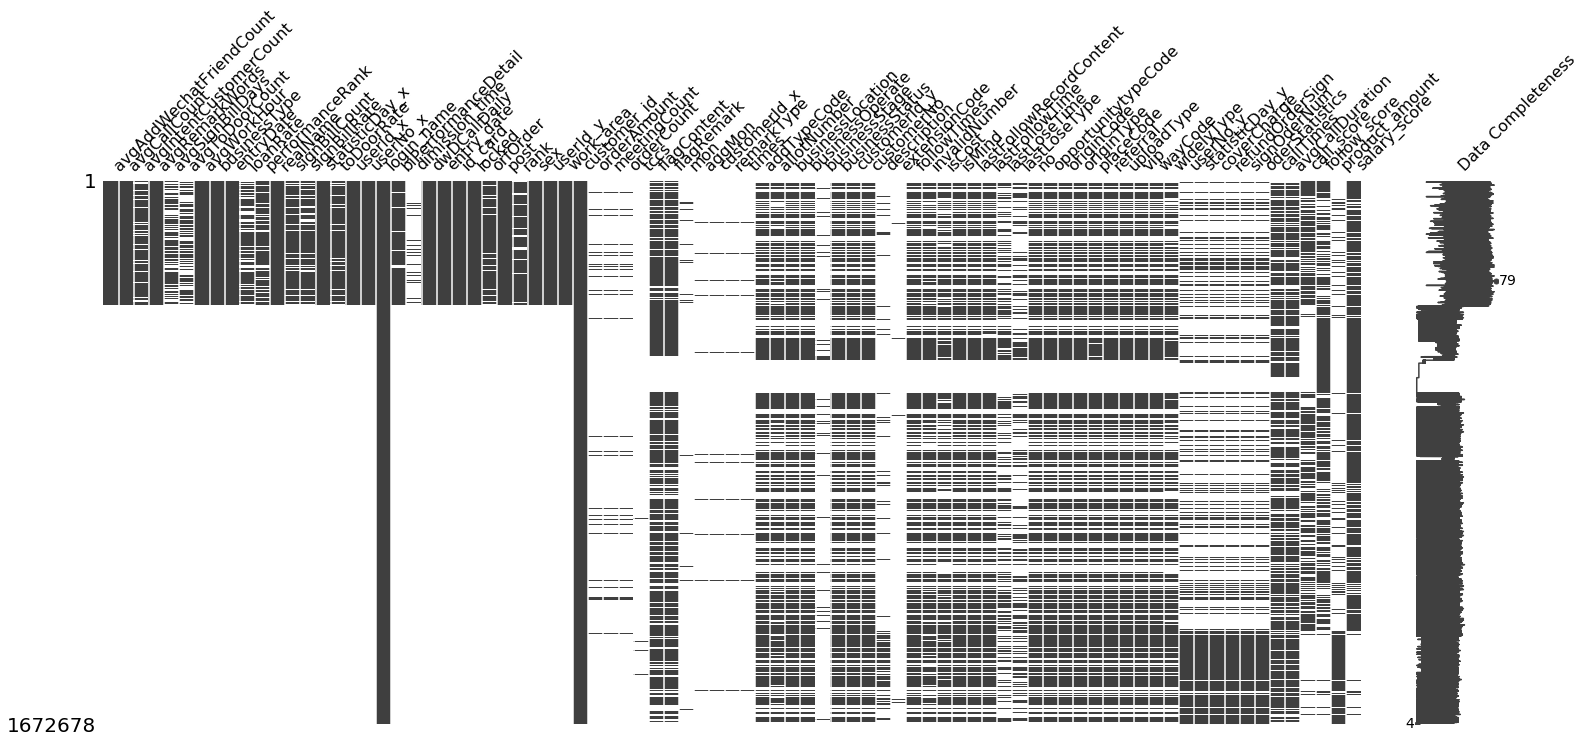

In [4]:
msno.matrix(df, labels=True)

In [8]:
print(df.isnull().mean())

avgAddWechatFriendCount    0.771029
avgCallCount               0.769956
avgIntentCustomerCount     0.805588
avgRemarkWords             0.769842
avgSignBillDays            0.862891
avgToDoorCount             0.875946
avgWorkHour                0.769856
businessType               0.769666
entryDate                  0.769666
loanRate                   0.843745
performanceRank            0.815598
realName                   0.769666
signBillCount              0.799796
signBillRate               0.809243
statisticDay_x             0.769666
toDoorRate                 0.799613
userId_x                   0.769666
userNo_x                   0.769666
login_name                 0.000000
biPerformanceDetail        0.788766
dimission_time             0.976979
dwDCallDaily               0.769778
entry_date                 0.769666
id_card                    0.769667
locked                     0.769666
orfOrder                   0.791246
post                       0.769666
rank                       0

In [7]:
missing_series = df.isnull().sum() / len(df) * 100
missing_series

avgAddWechatFriendCount    77.102885
avgCallCount               76.995572
avgIntentCustomerCount     80.558840
avgRemarkWords             76.984213
avgSignBillDays            86.289112
avgToDoorCount             87.594564
avgWorkHour                76.985588
businessType               76.966637
entryDate                  76.966637
loanRate                   84.374518
performanceRank            81.559810
realName                   76.966637
signBillCount              79.979590
signBillRate               80.924302
statisticDay_x             76.966637
toDoorRate                 79.961296
userId_x                   76.966637
userNo_x                   76.966637
login_name                  0.000000
biPerformanceDetail        78.876568
dimission_time             97.697883
dwDCallDaily               76.977816
entry_date                 76.966637
id_card                    76.966697
locked                     76.966637
orfOrder                   79.124554
post                       76.966637
r

In [9]:
missing_series.reset_index()

,index,0
0,avgAddWechatFriendCount,77.102885
1,avgCallCount,76.995572
2,avgIntentCustomerCount,80.558840
3,avgRemarkWords,76.984213
4,avgSignBillDays,86.289112
5,avgToDoorCount,87.594564
6,avgWorkHour,76.985588
7,businessType,76.966637
8,entryDate,76.966637
9,loanRate,84.374518


In [10]:
df.columns

Index(['avgAddWechatFriendCount', 'avgCallCount', 'avgIntentCustomerCount',
       'avgRemarkWords', 'avgSignBillDays', 'avgToDoorCount', 'avgWorkHour',
       'businessType', 'entryDate', 'loanRate', 'performanceRank', 'realName',
       'signBillCount', 'signBillRate', 'statisticDay_x', 'toDoorRate',
       'userId_x', 'userNo_x', 'login_name', 'biPerformanceDetail',
       'dimission_time', 'dwDCallDaily', 'entry_date', 'id_card', 'locked',
       'orfOrder', 'post', 'rank', 'sex', 'userId_y', 'work_area',
       'customer_id', 'orderAmount', 'meetingCount', 'orderCount', 'tccs',
       'flagContent', 'flagRemark', 'mon', 'aggMon', 'customerId_x',
       'remarkType', 'times', 'addTypeCode', 'allotNumber', 'businessLocation',
       'businessOperate', 'businessStage', 'businessStatus', 'customerId_y',
       'customerNo', 'description', 'extensionCode', 'followTimes',
       'invalidNumber', 'isCost', 'isMind', 'lastFollowRecordContent',
       'lastFollowTime', 'lastLoseTime', 'las

In [11]:
print(len(set(df['business_id'].value_counts().tolist())))

21


In [12]:
print(len(set(df['login_name'].value_counts().tolist())))

1013


In [14]:
df.login_name.unique().shape[0]

1896

In [15]:
df.business_id.unique().shape[0]

659133